## Импорт пакетов

In [ ]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os, json
import pandas as pd
import torch
import cv2
import torchvision

from PIL import Image, ImageDraw
from typing import Tuple
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=5498cab14a8bd765c7299ae7fff5973462d4db671eb22e1204359cedb7ff439f
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


## Вход в аккаунты

Wandb

In [ ]:
import wandb
# 33179bde83b2d45e312eac2814c25ec2c193887d
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Google drive




In [ ]:
from google.colab import drive

In [ ]:
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Mounted at /content/drive


## Global vars

In [ ]:
DATASET_PATH = '/content/drive/My Drive/datasets/YablokiAll/'
NUM_CLASSES = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
DEVICE

device(type='cuda')

## Функции для извлечения и показа картинок и таргетов

In [ ]:
folder_name = 'red_old'
img_name = 'DSC_7743.JPG'

In [ ]:
def get_img(folder_name, img_name, to_np = True):
    img_path = DATASET_PATH + folder_name + '/' + img_name
    image = Image.open(img_path)
    if to_np:
        image = np.asarray(image)
    return image

In [ ]:
def get_dots_and_labels(folder_name, img_name):
    folder =  DATASET_PATH + folder_name +'/'
    json_file = [folder + file for file in os.listdir(folder) if file.endswith('.json')][0]
    metadata = json.load(open(json_file))['_via_img_metadata']
    try:
        regions = [metadata[m] for m in metadata if metadata[m]['filename'] == img_name][0]['regions']
    except:
        return None, None
    dots = [list(zip(r['shape_attributes']['all_points_x'], r['shape_attributes']['all_points_y'])) for r in regions]
    labels = [r['region_attributes']['type_apple'].split('_')[-1] for r in regions]
    return dots, labels

In [ ]:
def get_masks(folder_name, img_name):
    image = get_img(folder_name, img_name)
    (h, w, _) = image.shape
    polygons, _ = get_dots_and_labels(folder_name, img_name)
    num_p = len(polygons)
    new_imgs = [Image.new('L', (w, h), 0) for _ in range(num_p)]
    for p, pol in enumerate(polygons):
        ImageDraw.Draw(new_imgs[p]).polygon(pol, outline=1, fill=1)
    masks = np.stack([np.array(new_img) for new_img in new_imgs])
    return masks

In [ ]:
def get_seg_target(folder_name, img_name):
    masks = get_masks(folder_name, img_name)
    mask = np.sum(masks, axis=0)
    return mask

In [ ]:
def overlay(
    image: np.ndarray,
    mask: np.ndarray,
    color: Tuple[int, int, int] = (255, 0, 0),
    alpha: float = 0.5, 
    resize: Tuple[int, int] = (1024, 1024)
) -> np.ndarray:
    
    image = np.moveaxis(image, -1, 0)
    color = np.asarray(color).reshape(3, 1, 1)
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()
    
    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)
    
    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
    image_combined = np.moveaxis(image_combined, 0, -1)
    
    return image_combined

In [ ]:
def get_image_with_segmentation_target(folder_name, img_name):
    masks = get_masks(folder_name, img_name)
    mask = np.sum(masks, axis=0)
    image = get_img(folder_name, img_name)
    it = overlay(image, mask, alpha=0.3, resize=None)
    return it

In [ ]:
def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    minx, miny, maxx, maxy = min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)
    # h, w = maxy - miny, maxx - minx
    return [(minx, miny), (maxx, maxy)]

In [ ]:
def get_img_with_boxes(img, bboxes, targets=False, scores=False, labels=False, dist=False, show=True):
    
    color = (255,104,0)
    text_color = (255,104,0) # (255,255,255)
    thick = 10
    
    # pred
    if scores and labels:
        for box, score, label in zip(bboxes, scores, labels):
            cv2.rectangle(img, box[0], box[1], color, thick)
            cv2.putText(img, f'{label} {score}', 
                        box[0], 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)
    # true        
    elif targets:
        for box, target in zip(bboxes, targets):
            cv2.rectangle(img, box[0], box[1], color, thick)
            cv2.putText(img, f'{target}', 
                        (box[0][0], box[0][1] - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5 * 4, text_color, 5, cv2.LINE_AA)
    # only boxes
    else:
        for box in bboxes:
            cv2.rectangle(img, box[0], box[1], color, thick)
 
    return img

In [ ]:
def get_image_with_detection_traget(folder_name, img_name):
    polygons, labels = get_dots_and_labels(folder_name, img_name)
    image = get_img(folder_name, img_name)
    bboxes = [bounding_box(pol) for pol in polygons]
    image = get_img_with_boxes(image, bboxes, targets=labels)
    return image

In [ ]:
def show_image(image, name, cmap=None):
    figure = plt.figure(figsize=(10, 10))
    plt.title('Image with detection target')
    plt.axis('off')
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)

In [ ]:
def show_image_with_targets_old(folder_name, img_name):
    image = get_img(folder_name, img_name)
    seg_target = get_seg_target(folder_name, img_name)
    image_with_seg_target = get_image_with_segmentation_target(folder_name, img_name)
    image_with_detection_target = get_image_with_detection_traget(folder_name, img_name)

    show_image(image, 'Image')
    show_image(seg_target, 'Segmentation target', cmap='Greys_r')
    show_image(image_with_seg_target, 'Image with segmentation target')
    show_image(image_with_detection_target, 'Image with detection target')

In [ ]:
def show_1_image_with_targets(folder_name, img_name):

    name = f'folder: {folder_name}\nimage: {img_name}'
    image = get_img(folder_name, img_name)
    (hi, wi, _) = image.shape

    seg_target = get_seg_target(folder_name, img_name)
    image_with_seg_target = get_image_with_segmentation_target(folder_name, img_name)
    image_with_detection_target = get_image_with_detection_traget(folder_name, img_name)

    if hi * wi < 500000:
        figure = plt.figure(figsize=(wi // 200 + 3, hi // 200 + 3))
    else:
        figure = plt.figure(figsize=(wi // 200, hi // 200))

    w, h = 2, 2

    plt.subplot(w, h, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(w, h, 2)
    plt.imshow(seg_target, cmap='Greys_r')
    plt.title('Segmentation target')
    plt.axis('off')

    plt.subplot(w, h, 3)
    plt.imshow(image_with_seg_target)
    plt.title('Image with\nsegmentation target')
    plt.axis('off')

    plt.subplot(w, h, 4)
    plt.imshow(image_with_detection_target)
    plt.title('Image with\ndetection target')
    plt.axis('off')

    plt.suptitle(name)
    plt.show()

## 🔸 Посмотрим на примеры размеченных картинок

In [ ]:
exs = {'red': ['DSC_8229.JPG', 'IMG_2773.JPG' ],
        'red_old' : ['DSC_7743.JPG', 'DSC_7817.JPG' ],
        'red_parsha': ['DSC_7856.JPG', 'DSC_8228.JPG'],
        'Механические повреждениея': ['IMG_0001.JPG', 'IMG_9909.JPG' ]}

In [ ]:
d = 'red'
show_1_image_with_targets(d, exs[d][0])
show_1_image_with_targets(d, exs[d][1])

In [ ]:
d = 'red_old'
show_1_image_with_targets(d, exs[d][0])
show_1_image_with_targets(d, exs[d][1])

Данные в папке red parsha оказались не размечены

In [ ]:
d = 'red_parsha'
# show_1_image_with_targets(d, exs[d][0])
# show_1_image_with_targets(d, exs[d][1])

In [ ]:
d = 'Механические повреждениея'
show_1_image_with_targets(d, exs[d][0])
show_1_image_with_targets(d, exs[d][1])


| Папка | Кол-во картинок | Описание |
|----------|----------|----------|
|red    | 63  | Картинки со средним количеством яблок  |
| red_old    | 4   | Картинки с большим количеством яблок   |
| ~~red_parsha~~   | 31   | Не размечены
| Механические повреждениея   | 135   | Картинки с яблоком с механическим повреждением по центру, но на фоне могут быть как яблоки с повреждением, так и без   

Некоторые картинки могут отсутствовать / не быть описаны в метаданных

Для задачи детекции таргеты требуют небольшой переработки, тк больше одного полигона (области) может отвечать за одно яблоко

Для задачи классификации:
у каждого полигона в каждой из трех размеченных папок есть тег 
- red_normal
- red_parsha
- red_mechanical



## 🔸 Преобразование датасета из json в csv

In [ ]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [ ]:
col_names = ['image_name', 'folder_name', 'label', 'box',	'image_width',	'image_height', 'box_width', 'box_height', 'box_area', 'polygon', 'polygon_area']

In [ ]:
df = pd.DataFrame(columns=col_names)

NameError: ignored

In [ ]:
for dirpath, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith('.JPG'):
            img_name, folder_name = file, dirpath.split('/')[-1]
            (ih, iw, _) = get_img(folder_name, img_name).shape
            polygons, labels = get_dots_and_labels(folder_name, img_name)
            if not polygons:
                continue
            boxes = [bounding_box(pol) for pol in polygons]
            heights = [b[1][1] - b[0][1] for b in boxes]
            widths = [b[1][0] - b[0][0] for b in boxes]
            for t in zip(labels, boxes, widths, heights, polygons):
                x, y = zip(*t[4])
                new_row = {'image_name': img_name,
                           'folder_name' : folder_name,
                           'label': t[0],
                           'box': t[1],
                           'image_width': iw,
                           'image_height': ih,
                           'box_width': t[2],
                           'box_height': t[3],
                           'box_area': t[2] * t[3],
                           'polygon': t[4],
                           'polygon_area': PolyArea(x, y)}
                df = df.append(new_row, ignore_index=True)   


In [ ]:
df

In [ ]:
df = df.astype({'image_width':int, 'image_height':int, 
                'box_width': int, 'box_height': int, 'box_area': int})

In [ ]:
csv = df.to_csv(DATASET_PATH + 'metadata.csv')

## 🔸 Аналитика

In [ ]:
df = pd.read_csv(DATASET_PATH + 'metadata.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    680 non-null    int64  
 1   image_name    680 non-null    object 
 2   folder_name   680 non-null    object 
 3   label         680 non-null    object 
 4   box           680 non-null    object 
 5   image_width   680 non-null    int64  
 6   image_height  680 non-null    int64  
 7   box_width     680 non-null    int64  
 8   box_height    680 non-null    int64  
 9   box_area      680 non-null    int64  
 10  polygon       680 non-null    object 
 11  polygon_area  680 non-null    float64
dtypes: float64(1), int64(6), object(5)
memory usage: 63.9+ KB


In [ ]:
df.describe()

,Unnamed: 0,image_width,image_height,box_width,box_height,box_area,polygon_area
count,680.000000,680.000000,680.000000,680.000000,680.000000,6.800000e+02,6.800000e+02
mean,339.500000,3642.742647,2297.910294,419.204412,399.500000,2.711679e+05,2.015312e+05
std,196.443376,1240.134409,664.928749,336.863036,315.956486,5.438105e+05,4.226620e+05
min,0.000000,574.000000,430.000000,26.000000,34.000000,1.376000e+03,6.880000e+02
25%,169.750000,2602.500000,2115.000000,207.750000,205.000000,4.126225e+04,2.901462e+04
50%,339.500000,4512.000000,2528.000000,322.500000,313.000000,9.863500e+04,6.961850e+04
75%,509.250000,4512.000000,2528.000000,496.500000,488.000000,2.424698e+05,1.804599e+05
max,679.000000,5184.000000,4990.000000,2578.000000,2678.000000,6.903884e+06,5.607488e+06


In [ ]:
df.isnull().sum()

Unnamed: 0      0
image_name      0
folder_name     0
label           0
box             0
image_width     0
image_height    0
box_width       0
box_height      0
box_area        0
polygon         0
polygon_area    0
dtype: int64

In [ ]:
df.corr()

,Unnamed: 0,image_width,image_height,box_width,box_height,box_area,polygon_area
Unnamed: 0,1.000000,0.225126,0.397333,-0.083814,-0.090756,-0.115757,-0.109189
image_width,0.225126,1.000000,0.811802,-0.328661,-0.339386,-0.213005,-0.199195
image_height,0.397333,0.811802,1.000000,-0.188505,-0.185011,-0.095189,-0.088061
box_width,-0.083814,-0.328661,-0.188505,1.000000,0.975707,0.916771,0.903735
box_height,-0.090756,-0.339386,-0.185011,0.975707,1.000000,0.915256,0.901728
box_area,-0.115757,-0.213005,-0.095189,0.916771,0.915256,1.000000,0.996269
polygon_area,-0.109189,-0.199195,-0.088061,0.903735,0.901728,0.996269,1.000000


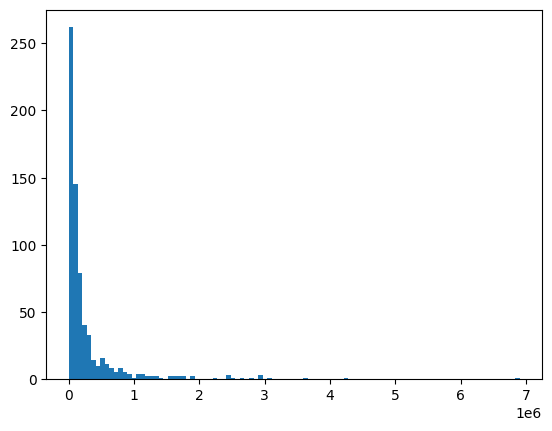

In [ ]:
plt.hist(df['box_area'], 100);

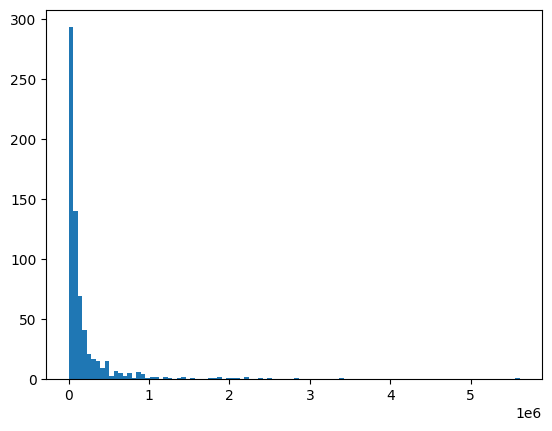

In [ ]:
plt.hist(df['polygon_area'], 100);

In [ ]:
notlistcols =  ['image_name', 'label', 'image_width',	'image_height',
                'box_width', 'box_height', 'box_area', 'polygon_area']

In [ ]:
some_cols = ['image_name', 'label']

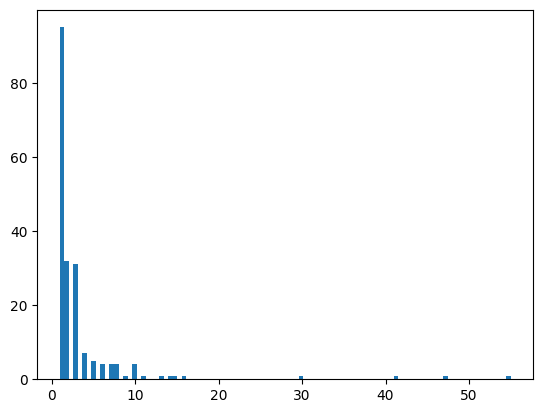

In [ ]:
# сколько размеченных яблок на одном фото
plt.hist(df['image_name'].value_counts(), 100);

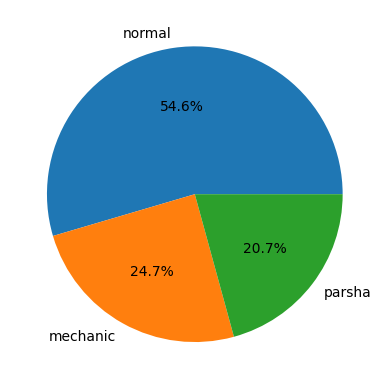

In [ ]:
# сколько яблок каждого класса
s = df['label'].value_counts()
plt.pie(s, labels=s.index, autopct='%1.1f%%');

In [ ]:
# сколько картинок
df['image_name'].nunique()

196

In [ ]:
type(df['image_name'].unique())

numpy.ndarray

In [ ]:
# groupby() - groups the data by one or more columns and applies an aggregation function (e.g. sum, mean, count) on each group.

## Dataset

In [ ]:
class AppleDataset(torch.utils.data.Dataset):
  
    def __init__(self, csv_path, img_dir_root, transforms, with_masks=False):
        self.img_dir_root = img_dir_root
        self.frame = pd.read_csv(csv_path)
        self.transforms = transforms
        self.img_list = self.frame['image_name'].unique()
        self.classes = ['bg', 'normal', 'parsha', 'mechanic']
        self.with_masks = with_masks

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        boxes_frame = self.frame[self.frame['image_name'] == img_name].reset_index()
        folder_name = boxes_frame.loc[0,'folder_name']
        img = get_img(folder_name, img_name, to_np = False)
      
        if self.with_masks:
            masks = get_masks(folder_name, img_name)
            masks = torch.as_tensor(masks, dtype=torch.uint8)

        num_objs = boxes_frame.shape[0]
        boxes, labels = [], []
        for i in range(num_objs):
            box = eval(boxes_frame.loc[i, 'box'])
            boxes.append([box[0][0], box[0][1], box[1][0], box[1][1]])
            labels.append(self.classes.index(boxes_frame.loc[i, 'label']))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}

        if self.with_masks:
            target["masks"] = masks

        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.img_list)

## Transforms

In [ ]:
# transforms.RandomResizedCrop(224),
# transforms.Resize(256),
# transforms.CenterCrop(224),
# transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
SIZE = 1024
# transforms.Resize(SIZE),

TRANSFORM = {

    'train': transforms.Compose([transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor()
                                 ]),

    'val_test': transforms.Compose([
                                    transforms.ToTensor(),
                                    # transforms.Resize(SIZE),
                                 ]),
}

In [ ]:
apple_dataset = AppleDataset(csv_path=DATASET_PATH + 'metadata.csv',
                  img_dir_root=DATASET_PATH, 
                  transforms=TRANSFORM['train'])

In [ ]:
len(apple_dataset)

196

In [ ]:
apple_dataset[0][0].shape

torch.Size([3, 2528, 4512])

In [ ]:
apple_dataset[195][0].shape

torch.Size([3, 3024, 4032])

## Dataloader

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
data_loader = torch.utils.data.DataLoader(apple_dataset, 
                                          batch_size=2, 
                                          shuffle=True, 
                                          num_workers=2,
                                          collate_fn=collate_fn)

## Models

In [ ]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
def get_model_instance_segmentation(num_classes, masks=False):

    if masks:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    else:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    if masks:
      
        # now get the number of input features for the mask classifier
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

        hidden_layer = 256

        # and replace the mask predictor with a new one
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                          hidden_layer,
                                                          num_classes)

    return model

## 🔸 Testing forward() method

In [ ]:
model = get_model_instance_segmentation(NUM_CLASSES, masks=True)

In [ ]:
images, targets = next(iter(data_loader))

In [ ]:
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections

In [ ]:
output

In [ ]:
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [ ]:
predictions

## Train-val-test split + dataloaders

In [ ]:
torch.manual_seed(0);

No masks

In [ ]:
# datasets with transforms

bs1 = 2

dataset_train = AppleDataset(csv_path=DATASET_PATH + 'metadata.csv',
                  img_dir_root=DATASET_PATH, 
                  transforms=TRANSFORM['train'])

dataset_val = AppleDataset(csv_path=DATASET_PATH + 'metadata.csv',
                  img_dir_root=DATASET_PATH, 
                  transforms=TRANSFORM['val_test'])

dataset_test = AppleDataset(csv_path=DATASET_PATH + 'metadata.csv',
                  img_dir_root=DATASET_PATH, 
                  transforms=TRANSFORM['val_test'])

# split

indices = torch.randperm(len(dataset_train)).tolist()

dataset_train = torch.utils.data.Subset(dataset_train, indices[:-40])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-40:-20])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-20:])

# dataloader

dataloader_train = DataLoader(dataset_train, 
                              batch_size=bs1, 
                              shuffle=True, 
                              num_workers=2,
                              collate_fn=collate_fn)

dataloader_val = DataLoader(dataset_val, 
                              batch_size=bs1, 
                              shuffle=True, 
                              num_workers=2,
                              collate_fn=collate_fn)

dataloader_test = DataLoader(dataset_test, 
                              batch_size=bs1, 
                              shuffle=True, 
                              num_workers=2,
                              collate_fn=collate_fn)

In [ ]:
len(dataset_train), len(dataset_val), len(dataset_test)

(156, 20, 20)

With masks

In [ ]:
bs2 = 1

In [ ]:
# datasets with transforms

dataset_masks_train = AppleDataset(csv_path=DATASET_PATH + 'metadata.csv',
                  img_dir_root=DATASET_PATH, 
                  transforms=TRANSFORM['train'], with_masks=True)

dataset_masks_val = AppleDataset(csv_path=DATASET_PATH + 'metadata.csv',
                  img_dir_root=DATASET_PATH, 
                  transforms=TRANSFORM['val_test'], with_masks=True)

dataset_masks_test = AppleDataset(csv_path=DATASET_PATH + 'metadata.csv',
                  img_dir_root=DATASET_PATH, 
                  transforms=TRANSFORM['val_test'], with_masks=True)

# split

indices = torch.randperm(len(dataset_masks_train)).tolist()

dataset_masks_train = torch.utils.data.Subset(dataset_masks_train, indices[:-40])
dataset_masks_val = torch.utils.data.Subset(dataset_masks_val, indices[-40:-20])
dataset_masks_test = torch.utils.data.Subset(dataset_masks_test, indices[-20:])

# dataloader

dataloader_masks_train = DataLoader(dataset_masks_train, 
                              batch_size=bs2, 
                              shuffle=True, 
                              num_workers=2,
                              collate_fn=collate_fn)

dataloader_masks_val = DataLoader(dataset_masks_val, 
                              batch_size=bs2, 
                              shuffle=True, 
                              num_workers=2,
                              collate_fn=collate_fn)

dataloader_masks_test = DataLoader(dataset_masks_test, 
                              batch_size=bs2, 
                              shuffle=True, 
                              num_workers=2,
                              collate_fn=collate_fn)

## Training func

In [ ]:
NUM_EPOCHS = 10

In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
def train(model, dataloader_train, dataloader_val, name):

    best_ap = 0

    model.to(DEVICE)

    # optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9,
                                weight_decay=0.0005)
    
    # learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    for epoch in range(NUM_EPOCHS):

        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, dataloader_train, DEVICE, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()

        # evaluate on the test dataset
        ap = evaluate(model, dataloader_val, device=DEVICE)
        print(ap)
        if ap > best_ap:
            best_ap = ap
            torch.save(model.state_dict(), f"/content/drive/My Drive/models/{name}.pt")

    print("That's it!")

## 🔴 mask train

In [ ]:
model_mask = get_model_instance_segmentation(NUM_CLASSES, masks=True)

test eval

In [ ]:
# run = wandb.init(project="Apple Detection", entity="c-nemo", reinit=True)

In [ ]:
# model_mask.to(DEVICE);

In [ ]:
# evaluate on test
# ap = evaluate(model_mask, dataloader_masks_test, device=DEVICE)

In [ ]:
# print(ap)

In [ ]:
# torch.save(model_mask.state_dict(), f"/content/drive/My Drive/models/mask1.pt")

In [ ]:
# run.finish()

normal train

In [ ]:
run = wandb.init(project="Apple Detection", entity="c-nemo", reinit=True)

In [ ]:
# train on train + evaluate on val
train(model_mask, dataloader_masks_train, dataloader_masks_val, 'mask1')

Epoch: [0]  [  0/156]  eta: 0:13:10  lr: 0.000037  loss: 7.2150 (7.2150)  loss_classifier: 1.2264 (1.2264)  loss_box_reg: 0.8240 (0.8240)  loss_mask: 5.1243 (5.1243)  loss_objectness: 0.0365 (0.0365)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 5.0671  data: 2.0713  max mem: 1565
Epoch: [0]  [ 10/156]  eta: 0:02:58  lr: 0.000359  loss: 3.7594 (3.8528)  loss_classifier: 0.7732 (0.7731)  loss_box_reg: 0.1693 (0.3013)  loss_mask: 2.4702 (2.6141)  loss_objectness: 0.0462 (0.1493)  loss_rpn_box_reg: 0.0107 (0.0150)  time: 1.2223  data: 0.4725  max mem: 1788
Epoch: [0]  [ 20/156]  eta: 0:02:01  lr: 0.000682  loss: 1.5352 (2.6022)  loss_classifier: 0.3617 (0.5305)  loss_box_reg: 0.1889 (0.2609)  loss_mask: 0.8780 (1.7017)  loss_objectness: 0.0152 (0.0978)  loss_rpn_box_reg: 0.0069 (0.0112)  time: 0.6844  data: 0.2378  max mem: 1788
Epoch: [0]  [ 30/156]  eta: 0:01:41  lr: 0.001004  loss: 1.1402 (2.0862)  loss_classifier: 0.2359 (0.4459)  loss_box_reg: 0.1990 (0.2365)  loss_mask: 0.5927 (1.2993) 

In [ ]:
run.finish()

In [ ]:
run = wandb.init(project="Apple Detection", entity="c-nemo", reinit=True)

In [ ]:
# evaluate on test
# evaluate(model_mask, dataloader_masks_test, device=DEVICE)

## mask test

In [ ]:
run = wandb.init(project="Apple Detection", entity="c-nemo", reinit=True)

wandb: Currently logged in as: c-nemo. Use `wandb login --relogin` to force relogin


In [ ]:
DEVICE

device(type='cuda')

In [ ]:
best_model_mask = get_model_instance_segmentation(NUM_CLASSES, masks=True)
best_model_mask.load_state_dict(torch.load("/content/drive/My Drive/models/mask1.pt"))

<All keys matched successfully>

In [ ]:
best_model_mask.to(DEVICE);

In [ ]:
evaluate(best_model_mask, dataloader_masks_test, device=DEVICE)

creating index...
index created!
Test:  [ 0/20]  eta: 0:03:00  model_time: 8.7967 (8.7967)  evaluator_time: 0.0148 (0.0148)  time: 9.0210  data: 0.2072  max mem: 595
Test:  [19/20]  eta: 0:00:02  model_time: 0.1797 (0.6378)  evaluator_time: 0.1868 (1.9637)  time: 2.6779  data: 0.0426  max mem: 9214
Test: Total time: 0:00:53 (2.6839 s / it)
Averaged stats: model_time: 0.1797 (0.6378)  evaluator_time: 0.1868 (1.9637)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.646
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.570
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

0.4899266768821241

In [ ]:
run.finish()

## 🔴 faster train

In [ ]:
run = wandb.init(project="Apple Detection", entity="c-nemo", reinit=True)

wandb: Currently logged in as: c-nemo. Use `wandb login --relogin` to force relogin


In [ ]:
model_fast = get_model_instance_segmentation(NUM_CLASSES, masks=False)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 49.0MB/s]


In [ ]:
# train on train + evaluate on val
train(model_fast, dataloader_train, dataloader_val, 'fast1')

Epoch: [0]  [ 0/78]  eta: 0:14:00  lr: 0.000070  loss: 2.1164 (2.1164)  loss_classifier: 1.8200 (1.8200)  loss_box_reg: 0.2210 (0.2210)  loss_objectness: 0.0705 (0.0705)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 10.7820  data: 1.8845  max mem: 2274
Epoch: [0]  [10/78]  eta: 0:02:04  lr: 0.000719  loss: 1.5013 (1.5293)  loss_classifier: 1.1541 (1.0827)  loss_box_reg: 0.2645 (0.3170)  loss_objectness: 0.0131 (0.1177)  loss_rpn_box_reg: 0.0048 (0.0119)  time: 1.8344  data: 0.4123  max mem: 3374
Epoch: [0]  [20/78]  eta: 0:01:16  lr: 0.001367  loss: 0.7737 (1.1823)  loss_classifier: 0.4279 (0.7596)  loss_box_reg: 0.2356 (0.2820)  loss_objectness: 0.0512 (0.1235)  loss_rpn_box_reg: 0.0046 (0.0172)  time: 0.8457  data: 0.2331  max mem: 3374
Epoch: [0]  [30/78]  eta: 0:01:00  lr: 0.002016  loss: 0.5302 (0.9810)  loss_classifier: 0.2508 (0.5855)  loss_box_reg: 0.1973 (0.2573)  loss_objectness: 0.0689 (0.1227)  loss_rpn_box_reg: 0.0066 (0.0155)  time: 0.9551  data: 0.3444  max mem: 3374
Epoch: 

In [ ]:
run.finish()

Последняя модель

In [ ]:
run = wandb.init(project="Apple Detection", entity="c-nemo", reinit=True)

In [ ]:
# evaluate on test
evaluate(model_fast, dataloader_test, device=DEVICE)

## faster test

In [ ]:
run = wandb.init(project="Apple Detection", entity="c-nemo", reinit=True)

In [ ]:
best_model_fast = get_model_instance_segmentation(NUM_CLASSES, masks=False)
best_model_fast.load_state_dict(torch.load("/content/drive/My Drive/models/fast1.pt"))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 229MB/s]


<All keys matched successfully>

In [ ]:
best_model_fast.to(DEVICE);

In [ ]:
evaluate(best_model_fast, dataloader_test, device=DEVICE)

creating index...
index created!
Test:  [ 0/10]  eta: 0:00:26  model_time: 0.4530 (0.4530)  evaluator_time: 0.0114 (0.0114)  time: 2.6816  data: 2.1051  max mem: 9214
Test:  [ 9/10]  eta: 0:00:00  model_time: 0.2463 (0.2670)  evaluator_time: 0.0051 (0.0300)  time: 0.8513  data: 0.4699  max mem: 9214
Test: Total time: 0:00:08 (0.8603 s / it)
Averaged stats: model_time: 0.2463 (0.2670)  evaluator_time: 0.0051 (0.0300)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.717
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU

0.558512157023643

In [ ]:
run.finish()

In [ ]:
best_model_mask.eval();

In [ ]:
best_model_mask.to('cpu');

In [ ]:
best_model_fast.eval();

In [ ]:
best_model_fast.to('cpu');

In [ ]:
images, targets = next(iter(dataloader_test))

In [ ]:
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

In [ ]:
output = best_model_mask(images, targets)

In [ ]:
output2 = best_model_fast(images, targets)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], 
                               orig_prediction['scores'],
                               iou_threshold=iou_thresh)
                               
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [ ]:
output[0]

{'boxes': tensor([[1933.8043, 1182.4261, 2430.4299, 1591.6188],
         [3376.5698, 1583.0894, 3693.1746, 1911.5940],
         [3649.0315,  576.5699, 3856.3394,  807.6628],
         [2566.3960,  408.6431, 3792.9094, 1256.3724],
         [1662.5385, 1089.3220, 3961.1594, 2341.7612]],
        grad_fn=<IndexBackward0>),
 'labels': tensor([2, 1, 1, 3, 3]),
 'scores': tensor([0.5994, 0.5064, 0.3732, 0.2048, 0.1372, 0.1214, 0.1190, 0.1093, 0.0786,
         0.0638, 0.0509], grad_fn=<IndexBackward0>),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,

In [ ]:
o1m, o2m = apply_nms(output[0], iou_thresh=0.2), apply_nms(output[1], iou_thresh=0.2)
o2m, o2f = apply_nms(output2[0], iou_thresh=0.2), apply_nms(output2[1], iou_thresh=0.2)

RuntimeError: ignored

In [ ]:
b1m, l1m = get_boxes(o1m['boxes'].detach()), get_labels(o1m['labels'].detach())
b2m, l2m = get_boxes(o2m['boxes'].detach()), get_labels(o2m['labels'].detach())

In [ ]:
b1f, l1f = get_boxes(o1f['boxes'].detach()), get_labels(o1f['labels'])
b2f, l2f = get_boxes(o2f['boxes'].detach()), get_labels(o2f['labels'])

dislay true 1

In [ ]:
targets;

In [ ]:
def get_box(b):
    return (b[0], b[1]), (b[2], b[3])

In [ ]:
import torchvision.transforms.functional as TF

In [ ]:
pil_image = np.array(TF.to_pil_image(images[0]))

In [ ]:
i2 = np.array(TF.to_pil_image(images[1]))

In [ ]:
def get_boxes(boxes):
    return np.apply_along_axis(get_box, 1, boxes.numpy()).astype(np.int32)

In [ ]:
boxes = get_boxes(targets[0]['boxes'])

In [ ]:
def decode(m):
    classes = [0, 'normal', 'parsha', 'mechanic']
    return classes[int(m)]

In [ ]:
def get_labels(labels):
    return np.apply_along_axis(decode, 1, labels.numpy().astype(np.int32)[:, np.newaxis])

In [ ]:
labels = get_labels(targets[0]['labels'])

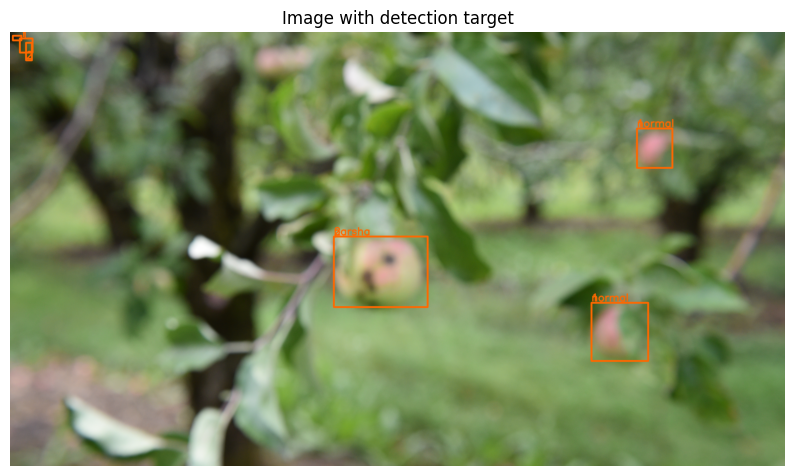

In [ ]:
img_true = get_img_with_boxes(pil_image, 
                              boxes,
                              targets=labels)
show_image(img_true, 'img_true')

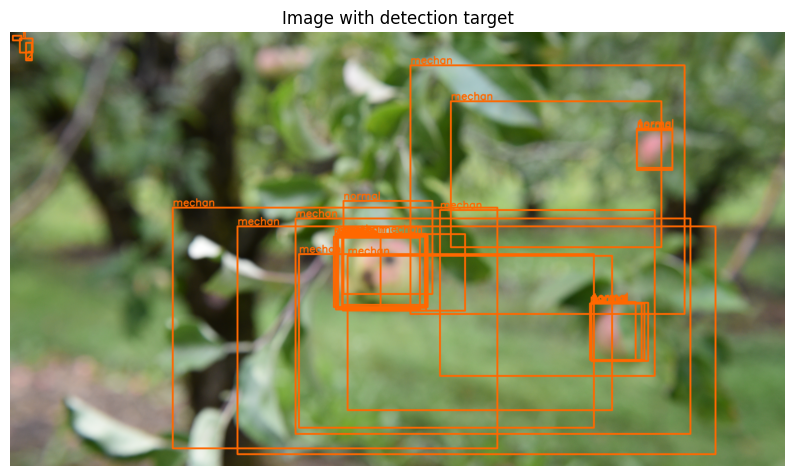

In [ ]:
img_true = get_img_with_boxes(pil_image, 
                              b1m,
                              targets=l1m)
show_image(img_true, 'img_pred_mask')

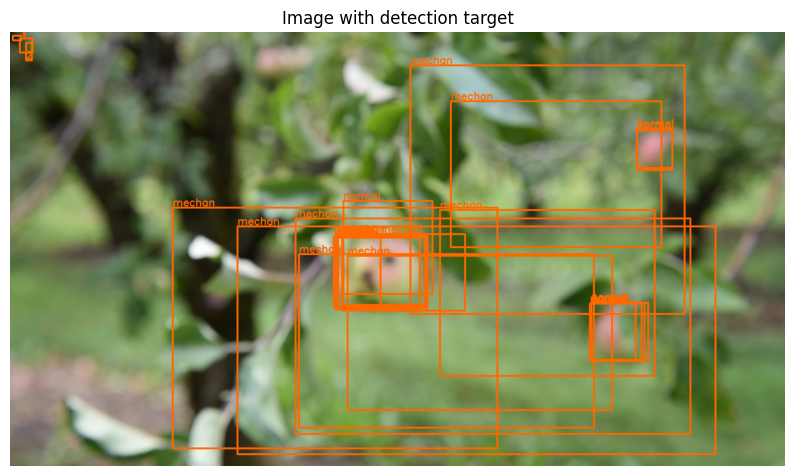

In [ ]:
img_true = get_img_with_boxes(pil_image, 
                              b1f,
                              targets=l1f)
show_image(img_true, 'img_pred_mask')

In [ ]:
img_true = get_img_with_boxes(i2, 
                              b2,
                              targets=l2)
show_image(img_true, 'img_true')

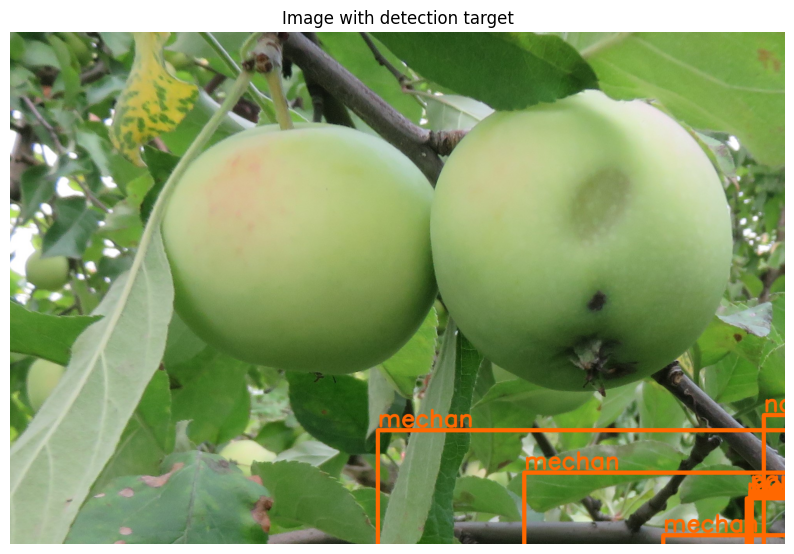

In [ ]:
img_true = get_img_with_boxes(i2, 
                              b2f,
                              targets=l2f)
show_image(img_true, 'img_pred_f')

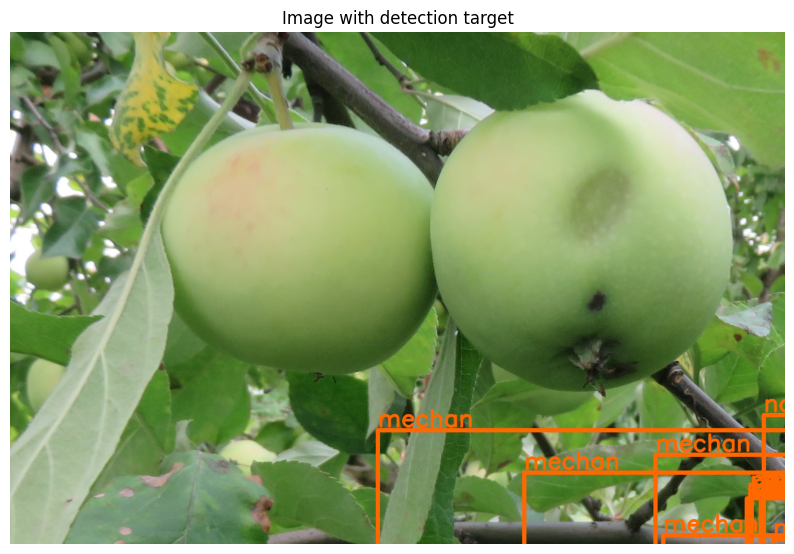

In [ ]:
img_true = get_img_with_boxes(i2, 
                              b2m,
                              targets=l2m)
show_image(img_true, 'img_pred_f')